In [2]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8MB 26kB/s 
     |████████████████████████████████| 6.6MB 37.1MB/s 
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101
     |████████████████████████████████| 276kB 6.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=68f16f93da16f45b9b26d37f9b182435103c5cf004251f6a64ab0175f056d156
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip

In [1]:
# mount your gdrive folder
from google.colab import drive
drive.mount('/content/drive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/ML_app_training


/content/drive/My Drive/ML_app_training


In [4]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 768kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200711-cp36-none-any.whl size=42285 sha256=2ab3db08db8619088e094c8bdf695dd7bdb7f3ff435fc2f4299ec4e69d0d9e85
  Stored in directory: /root/.cache/pip/wheels/be/e2/ff/183aa84c45c7f0a6f55d2a40bdbfc00e9d5c36b492065ec526
Successfully built fvcore


In [5]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger

import detectron2
from detectron2.utils.logger import setup_logger
#setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [10]:
import os
import datetime
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

# create the output dir for the trained model
output_dir = os.path.join("/content/drive/My Drive/ML_app_training/output_freeze2", "20200713T1732")
# change the config in the .yaml document
print(output_dir)

/content/drive/My Drive/ML_app_training/output_freeze2/20200713T1732


In [7]:

# Register a dataset in COCO’s json annotation format for instance detection, instance segmentation and keypoint detection. 
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/drive/My Drive/ML_app_training/new_annotations/train/train_coco.json", "/content/drive/My Drive/ML_app_training/new_annotations/train")
register_coco_instances("my_dataset_val", {}, "/content/drive/My Drive/ML_app_training/new_annotations/val/val_coco.json", "/content/drive/My Drive/ML_app_training/new_annotations/val")
register_coco_instances("my_dataset_test", {}, "/content/drive/My Drive/ML_app_training/new_annotations/test/test_coco.json", "/content/drive/My Drive/ML_app_training/new_annotations/test")

In [15]:
from detectron2.data import DatasetCatalog, MetadataCatalog

papers_metadata = MetadataCatalog.get("my_dataset_train") #return the Metadata instance associated with this name
dataset_dicts = DatasetCatalog.get("my_dataset_train") # Call the registered function and return dataset annotations


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [12]:
cfg = get_cfg() #load default config
cfg.merge_from_file(output_dir + "/train_config_freeze2.yaml")
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("my_dataset_val", )
predictor = DefaultPredictor(cfg)

In [13]:
predictor

In [22]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

from detectron2.utils.visualizer import ColorMode
dataset_dicts_val = DatasetCatalog.get("my_dataset_val")
for d in dataset_dicts_val:    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=papers_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.

In [26]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir=output_dir)
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [07/14 10:58:46 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/14 10:58:46 d2.data.datasets.coco]: Loaded 17 images in COCO format from /content/drive/My Drive/ML_app_training/new_annotations/val/val_coco.json
[07/14 10:58:46 d2.data.common]: Serializing 17 elements to byte tensors and concatenating them all ...
[07/14 10:58:46 d2.data.common]: Serialized dataset takes 0.02 MiB
[07/14 10:58:46 d2.evaluation.evaluator]: Start inference on 17 images
[07/14 10:58:54 d2.evaluation.evaluator]: Inference done 11/17. 0.7150 s / img. ETA=0:00:04
[07/14 10:58:59 d2.evaluation.evaluator]: Total inference time: 0:00:08.764820 (0.730402 s / img per device, on 1 devices)
[07/14 10:58:59 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:08 (0.716988 s / img per device, on 1 devices)
[07/14 10:58:59 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/14 10:58:59 d2.evaluation.coco_eval

OrderedDict([('bbox',
              {'AP': 17.658890522751907,
               'AP-abstract': 40.56859971711456,
               'AP-address': 7.7227722772277225,
               'AP-affiliation': 3.86138613861386,
               'AP-author': 32.73900604346149,
               'AP-date': 10.307637906647807,
               'AP-doi': 0.0,
               'AP-email': 0.0,
               'AP-journal': 16.61386138613861,
               'AP-title': 47.11675123556311,
               'AP50': 26.861236355266644,
               'AP75': 19.580405411797372,
               'APl': 29.27382916863115,
               'APm': 18.44733248835087,
               'APs': 5.6506364922206505}),
             ('segm',
              {'AP': 16.676766577756677,
               'AP-abstract': 40.67326732673267,
               'AP-address': 5.148514851485148,
               'AP-affiliation': 2.5742574257425734,
               'AP-author': 32.577999558197575,
               'AP-date': 10.806223479490807,
               'AP-d

Making predictions on the test set

[07/14 11:33:36 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

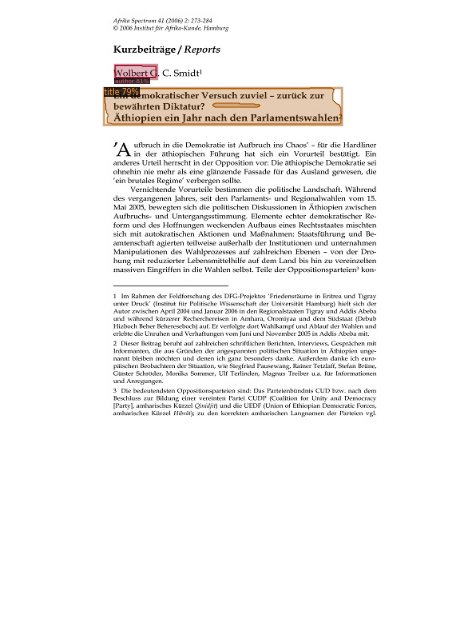

/content/drive/My Drive/ML_app_training/new_annotations/test/11164


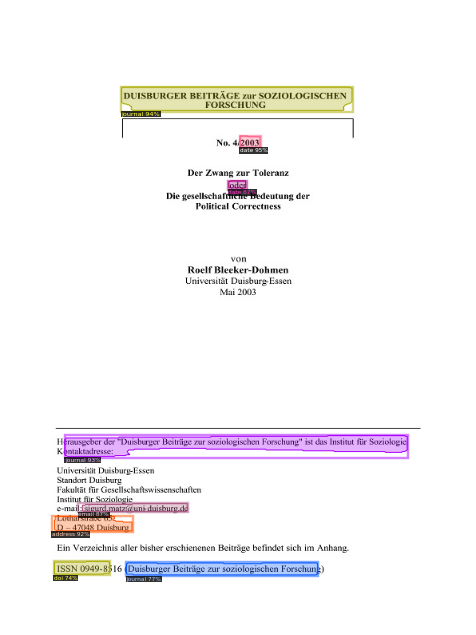

/content/drive/My Drive/ML_app_training/new_annotations/test/11190


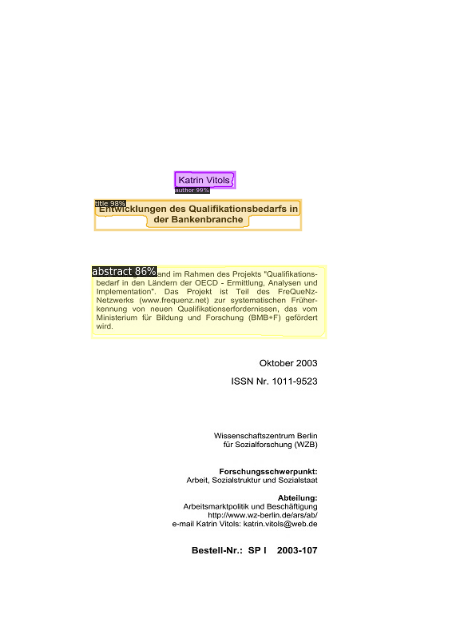

/content/drive/My Drive/ML_app_training/new_annotations/test/11448


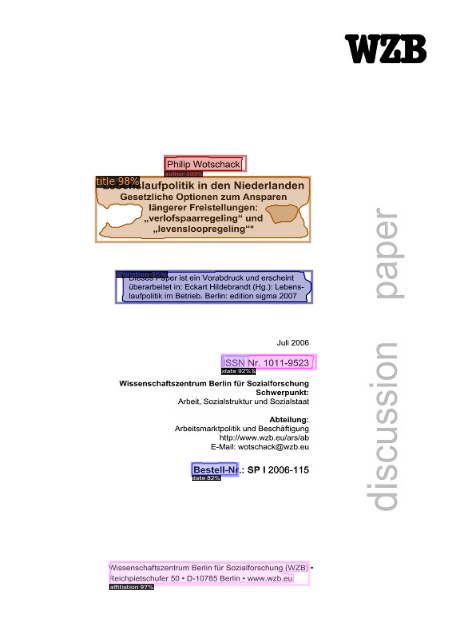

/content/drive/My Drive/ML_app_training/new_annotations/test/12797


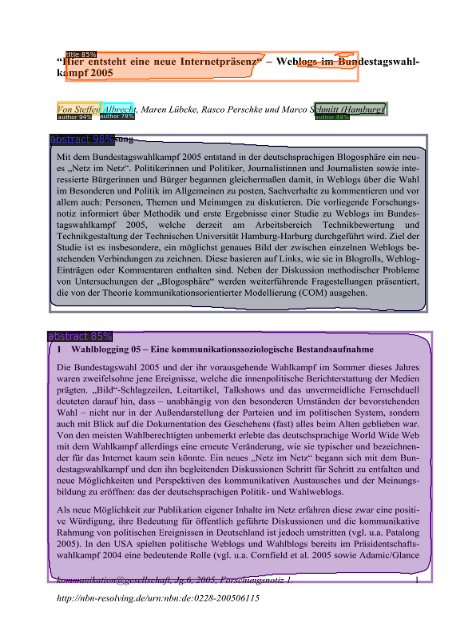

/content/drive/My Drive/ML_app_training/new_annotations/test/17492


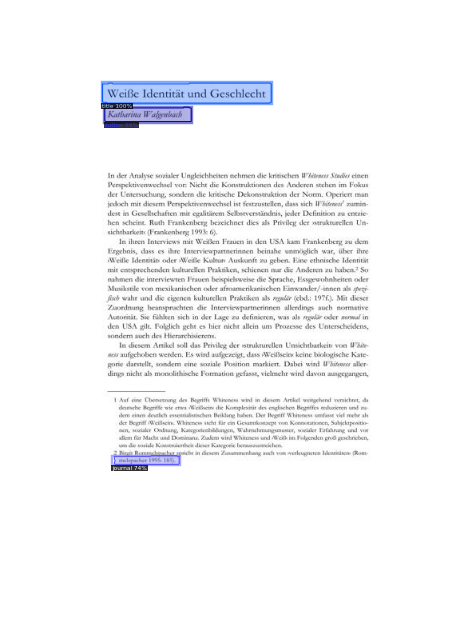

/content/drive/My Drive/ML_app_training/new_annotations/test/19396


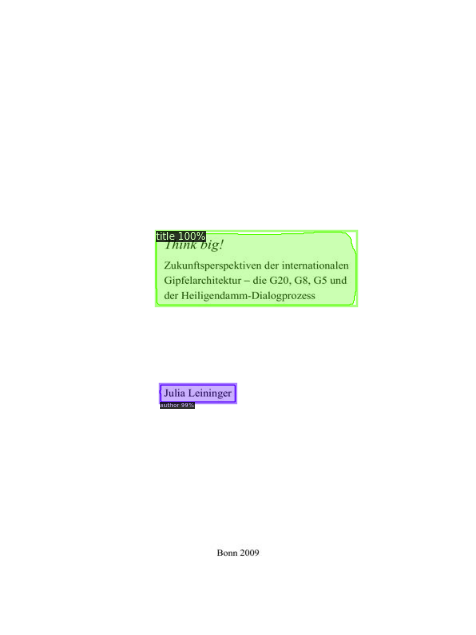

/content/drive/My Drive/ML_app_training/new_annotations/test/22006


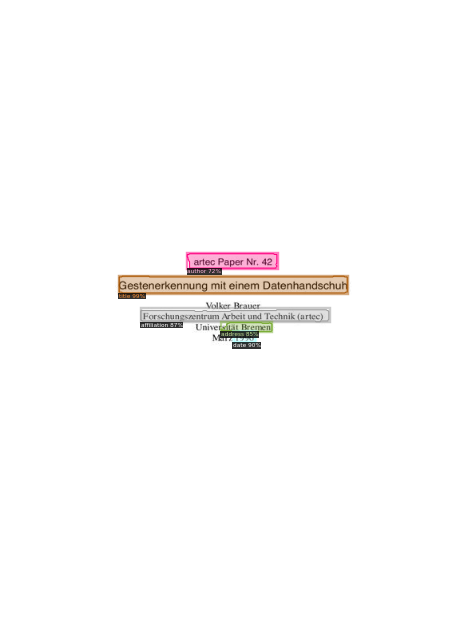

/content/drive/My Drive/ML_app_training/new_annotations/test/31474


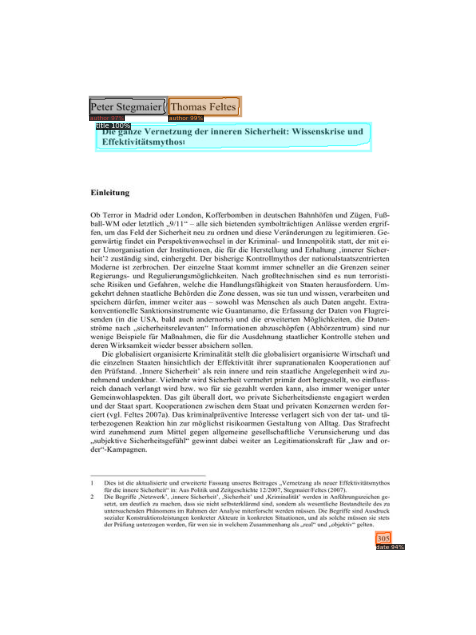

In [37]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

from detectron2.utils.visualizer import ColorMode
dataset_dicts_test = DatasetCatalog.get("my_dataset_test")
for d in dataset_dicts_test:    
    im = cv2.imread(d["file_name"])
    print(d["file_name"][:-5])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=papers_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2.imwrite(d["file_name"][:-5] + "_test.png", v.get_image()[:, :, ::-1])
    cv2_imshow(v.get_image()[:, :, ::-1])

In [34]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir=output_dir)
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [07/14 11:32:33 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/14 11:32:33 d2.data.datasets.coco]: Loaded 9 images in COCO format from /content/drive/My Drive/ML_app_training/new_annotations/test/test_coco.json
[07/14 11:32:33 d2.data.common]: Serializing 9 elements to byte tensors and concatenating them all ...
[07/14 11:32:33 d2.data.common]: Serialized dataset takes 0.01 MiB
[07/14 11:32:33 d2.evaluation.evaluator]: Start inference on 9 images
[07/14 11:32:40 d2.evaluation.evaluator]: Total inference time: 0:00:02.933894 (0.733474 s / img per device, on 1 devices)
[07/14 11:32:40 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.711882 s / img per device, on 1 devices)
[07/14 11:32:40 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/14 11:32:40 d2.evaluation.coco_evaluation]: Saving results to /content/drive/My Drive/ML_app_training/output_freeze2/20200713T17

OrderedDict([('bbox',
              {'AP': 23.297396406307293,
               'AP-abstract': 80.0,
               'AP-address': 0.0,
               'AP-affiliation': 1.4851485148514851,
               'AP-author': 23.234323432343235,
               'AP-date': 7.72277227722772,
               'AP-doi': 8.415841584158414,
               'AP-email': 0.0,
               'AP-journal': 30.297029702970292,
               'AP-title': 58.521452145214525,
               'AP50': 33.93839383938394,
               'AP75': 23.826549321598826,
               'APl': 49.94499449944994,
               'APm': 14.041872937293729,
               'APs': 3.3663366336633653}),
             ('segm',
              {'AP': 22.390447378071137,
               'AP-abstract': 89.99999999999999,
               'AP-address': 0.0,
               'AP-affiliation': 0.7425742574257426,
               'AP-author': 24.471947194719473,
               'AP-date': 10.297029702970292,
               'AP-doi': 8.415841584158414,
 